In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from snntorch import spikegen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.optim as optim
from spikingjelly.activation_based import functional, neuron, surrogate
import pynvml  # For GPU power usage monitoring
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Initialize NVML for GPU power usage measurement
pynvml.nvmlInit()
gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)

def get_gpu_power_usage():
    return pynvml.nvmlDeviceGetPowerUsage(gpu_handle) / 1000  # in watts

In [17]:


# Global parameters
num_steps = 5
batch_size = 64
learning_rate = 1e-3
epochs = 5
data_path = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data'
model_save_path = '/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth'

# Transformations for images
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load datasets
train_data = datasets.ImageFolder(root=f'{data_path}/train', transform=transform)
test_data = datasets.ImageFolder(root=f'{data_path}/test', transform=transform)

# Sampling for class balancing
targets = train_data.targets
class_counts = np.bincount(targets)
class_weights = 1. / class_counts
sample_weights = [class_weights[t] for t in targets]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoaders
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print('GPU available:', torch.cuda.is_available())  # Check if GPU is accessible

# Define SNN with ResNet18 as encoder
class ResNetSNN(nn.Module):
    def __init__(self, in_channels, timesteps, n_classes):
        super(ResNetSNN, self).__init__()
        self.timesteps = timesteps
        resnet = models.resnet18(pretrained=True)

        # Modify the first convolutional layer to accept grayscale images
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Replace fully connected layer
        resnet.fc = nn.Linear(resnet.fc.in_features, n_classes)

        # Define layers
        self.encoder = resnet
        self.lif = neuron.LIFNode(tau=2.0, surrogate_function=surrogate.Sigmoid())

    def forward(self, x):
        # Input shape: [time_steps, batch, channels, height, width]
        out = 0
        for t in range(self.timesteps):
            x_t = self.encoder(x[t])  # Pass data through ResNet encoder
            x_t = self.lif(x_t)  # Apply LIF neurons
            out += x_t
        out /= self.timesteps  # Average over timesteps
        functional.reset_net(self)  # Reset neuron states
        return out

# Initialize model and transfer to GPU
model = ResNetSNN(in_channels=1, timesteps=num_steps, n_classes=7).to('cuda')

GPU available: True


/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [18]:
# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training function
def train_model(train_loader, model, optimizer, criterion, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            spike_data = spikegen.rate(images, num_steps=num_steps).to('cuda')  # Encode as spikes
            outputs = model(spike_data)
            loss = criterion(outputs, labels.to('cuda'))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels.to('cuda')).sum().item()
            total += labels.size(0)

        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

In [19]:
# Testing function
def test_model(test_loader, model):
    model.eval()
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in test_loader:
            spike_data = spikegen.rate(images, num_steps=num_steps).to('cuda')
            outputs = model(spike_data)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes).plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

Epoch 1/5, Loss: 871.0466, Accuracy: 16.47%
Epoch 2/5, Loss: 859.3715, Accuracy: 20.32%
Epoch 3/5, Loss: 829.7731, Accuracy: 23.33%
Epoch 4/5, Loss: 784.4057, Accuracy: 31.71%
Epoch 5/5, Loss: 759.4172, Accuracy: 36.87%


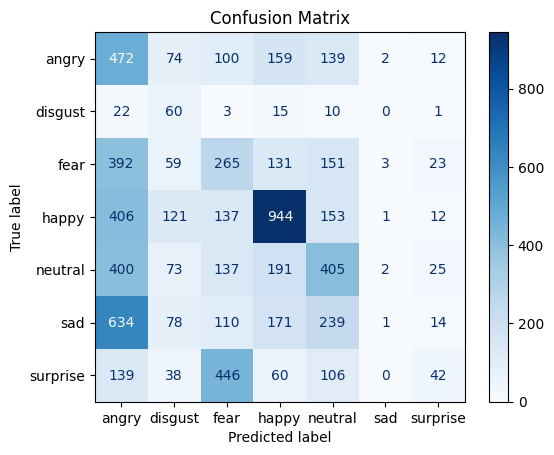

In [20]:
# Train and test the model
train_model(train_loader, model, optimizer, criterion, epochs)
test_model(test_loader, model)

In [21]:

# Save the trained model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved at {model_save_path}")

# Reload the model
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cuda')))
model.eval()
print(f"Model reloaded from {model_save_path}")

Model saved at /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth
Model reloaded from /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/training/resultats/snn18_model.pth


/tmp/ipykernel_11975/2924682366.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cuda')))


In [22]:
# Testing on a single image
def test_single_image(image_path, model, timesteps, class_names):
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.Grayscale(),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    spike_data = spikegen.rate(image_tensor, num_steps=timesteps).to('cuda')

    with torch.no_grad():
        outputs = model(spike_data)
        _, prediction = torch.max(outputs.mean(0), 0)  # Mean over timesteps

    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted Class: {class_names[prediction.item()]}")
    plt.axis("off")
    plt.show()

    return class_names[prediction.item()]

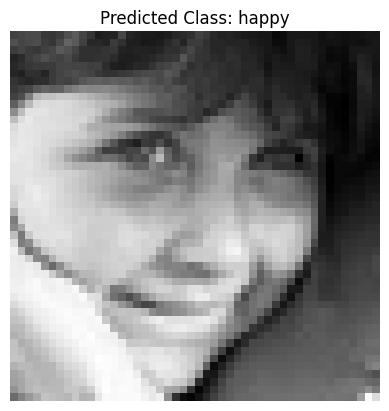

Predicted Class: happy


In [23]:
# Test single image
class_names = train_data.classes
test_image_path = "/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/happy/PrivateTest_258543.jpg"
predicted_class = test_single_image(test_image_path, model, num_steps, class_names)
print(f"Predicted Class: {predicted_class}")